In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE


ROOT = "C:/Users/mabid/OneDrive/Desktop/Projects - Ongoing/BNP Credit Card Fraud Detection/fraud_detection/"
sys.path.append(ROOT)

from src.visualization.evaluation_report import Model, GenerateReport
from src.features.build_features import ColumnManipulatorDrop, CleanItems, preprocess, ProcessingPipeline

C:\Users\mabid\OneDrive\Desktop\Projects - Ongoing\BNP Credit Card Fraud Detection\fraud_detection


## 1 - Custom Classes for Pipelining (Do not modify)

In [10]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

def remove_special_characters(column):
    return column.str.replace("[\s&,-]", "", regex=True)

def plot_precision_recall_curve(true_labels, preds):
    precision, recall, thresholds = precision_recall_curve(true_labels, preds)
    map = average_precision_score(true_labels, preds)

    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Average Precision Score: {map:.4f}')

    # Plot the baseline diagonal line
    plt.plot([0, 1], [1, 0], linestyle='--', label='Baseline')

    plt.legend()
    plt.show()


def create_submission(prob_predictions, index, filename):
    res = pd.DataFrame({'ID': index, 'fraud_flag': prob_predictions})
    res.reset_index(inplace=True)
    res.rename(columns={'index': 'index'}, inplace=True)
    res.to_csv(filename, index=False)

def find_make_model(row, roadmap):
    id = row['goods_code1']
    make, model = roadmap.loc[roadmap['goods_code1'] == id, ['make1', 'model1']].values[0] if len(roadmap.loc[roadmap['goods_code1'] == id]) > 0 else (np.nan, np.nan)
    return make, model

class SpecialCharacterRemover(BaseEstimator, TransformerMixin):
    def __init__(self, col) -> None:
        self.col = col

    def fit(self, data):
        return self

    def transform(self, data):
        if self.col == "item":
            filtered_columns = data.filter(like=self.col).filter(regex='^(?!Nb_of_items$)')
            data[filtered_columns.columns] = data[filtered_columns.columns].apply(remove_special_characters)
        else:
            filtered_columns = data.filter(like=self.col).filter(regex='^(?!Nb_of_items$)')
            data[filtered_columns.columns] = data[filtered_columns.columns].apply(remove_special_characters)
        return data

class MakeModelModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        self.roadmap_ = None

    def fit(self, data):
        self.roadmap_ = data[data['make1'].notnull() & data['model1'].notnull()].groupby('goods_code1').agg({'make1': 'max', 'model1': 'max'}).reset_index()
        return self

    def transform(self, data):
        make_model_indices = data.loc[(data['make1'].isnull()) & (data['model1'].isnull()), ['make1', 'model1']].index

        temp = data.loc[make_model_indices].apply(lambda x: find_make_model(x, self.roadmap_), axis=1)
        data.loc[make_model_indices, ['make1', 'model1']] = pd.DataFrame(temp.tolist(), columns=['make', 'model'])

        data["imputed_goods_code"] = 0
        data.loc[make_model_indices, "imputed_goods_code"] = 1 

        return data

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, remove_outliers = True) -> None:
        self.remove_outliers = remove_outliers

    def fit(self, data, y=None):
        return self

    def transform(self, data):
        #display(data)
        temp_features = pd.DataFrame()
        temp_features["Total_price"] = data.loc[:, [col for col in data.columns if "cash_price" in col]].sum(axis=1)
        temp_features["Total_items"] = data.loc[:, [f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]].sum(axis=1)
        temp_features["Price_per_total_purchases"] = temp_features["Total_price"] / temp_features["Total_items"]
        temp_features["Price_per_unique_item"] = temp_features["Total_price"] / data["Nb_of_items"]

        data = pd.concat([data, temp_features], axis=1)

        # Rearrange the columns
        columns_rearranged = []
        for i in range(1, 25):
            columns_to_reindex = [f'item{i}', f'cash_price{i}', f'make{i}', f'model{i}', f'goods_code{i}', f'Nbr_of_prod_purchas{i}']
            columns_rearranged.extend(columns_to_reindex)

        columns_rearranged += ["Nb_of_items", "Total_price", "Total_items", "Price_per_total_purchases", "Price_per_unique_item", "imputed_goods_code", "fraud_flag"]

        # Reindex the dataframe with the rearranged columns
        data = data.reindex(columns=columns_rearranged)

        # Drop unnecessary columns
        for i in range(4, 25):
            columns_to_drop = [f'item{i}', f'cash_price{i}', f'make{i}', f'model{i}', f'goods_code{i}', f'Nbr_of_prod_purchas{i}']
            data = data.drop(columns_to_drop, axis=1)

        if self.remove_outliers:
            q1_non_fraud = data.loc[data["fraud_flag"] == 0, "Price_per_total_purchases"].quantile(0.25)
            q3_non_fraud = data.loc[data["fraud_flag"] == 0, "Price_per_total_purchases"].quantile(0.75)
            iqr_non_fraud = q3_non_fraud - q1_non_fraud
            outlier_threshold = q3_non_fraud + 1.5 * iqr_non_fraud
            data = data.drop(data.loc[(data["fraud_flag"] == 0) & (data["Price_per_total_purchases"] > outlier_threshold)].index)

        return data
    
class CategoryModifier(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        self.columns_to_keep = None

    def fit(self, data, col, p_value = 0.05, min_samples = 100):
        temp = pd.get_dummies(data, columns=[col], drop_first=True, dtype=int)
        temp_columns = temp.filter(like=col + '_')
        temp_columns["fraud_flag"] = temp["fraud_flag"].copy()


        results = pd.DataFrame()
        for col in temp_columns.columns:   
            instances = temp_columns[col].sum()
            fraud_count = temp_columns.loc[temp_columns["fraud_flag"] == 1, col].sum()
            contingency_table = pd.crosstab(temp_columns[col], temp_columns["fraud_flag"])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            results = pd.concat([results, pd.DataFrame({"Column": [col], "Instances": [instances], "Fraud_count": [fraud_count], "Chi2": [chi2], "p-value": [p_value]})], axis=0)

        results = results[~(results["Column"] == "fraud_flag")]
        display(results.sort_values(by="p-value", ascending=True))

        columns_to_keep = results.loc[(results["p-value"] < 0.05) & (results["Instances"] > 100), "Column"].values
        columns_to_keep = [col for col in columns_to_keep if col != "fraud_flag"] 

        self.columns_to_keep = columns_to_keep

        return self
    
    def transform(self, data, col, fraud_yn = True):
        one_hot = pd.get_dummies(data, columns=[col], drop_first=True, dtype=int)
        one_hot = one_hot.filter(like=col + '_')

        #display(one_hot)

        one_hot[col + "_OTHER"] = one_hot.drop(columns=self.columns_to_keep, axis=1).sum(axis=1)
        one_hot = one_hot[self.columns_to_keep + [col + "_OTHER"]]
        
        return one_hot

## 2 - Import both test and train data, clean, add features and encode using manual OH Encoding (Do not modify)

In [24]:
TRAIN_DATA = "data/processed/model_train_data.csv"
#PARAMS_FILE = "../models/01-Anas-XGBTuned-14_02_2024.pickle"
OUTPUT_FILE_NAME = f"../models/01-Anas-XGBTuned-{time.strftime('%d_%b_%Y_%H_%M_%S')}.pickle"
RANDOM_STATE = 42


df_train = pd.read_csv(TRAIN_DATA, index_col=0)
df_train = df_train.drop(df_train.loc[df_train["Nb_of_items"] > 24].index)
y = df_train.pop("fraud_flag")

# Split the data & train the model (xgbDMatrix usde)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train, y, train_size=0.8, random_state=RANDOM_STATE)

pipeline_train = Pipeline([
    ('item_make_model', SpecialCharacterRemover('item')),
    ('make_make_model', SpecialCharacterRemover('make')),
    ('model_make_model', SpecialCharacterRemover('model')),
    ('impute_make_model', MakeModelModeImputer()),
    ('feature_engineering', FeatureEngineeringTransformer(remove_outliers=True)),
])

pipeline_train.fit(X_train)
X_train_tf = pipeline_train.transform(X_train)


pipeline_test = Pipeline([
    ('item_make_model', SpecialCharacterRemover('item')),
    ('make_make_model', SpecialCharacterRemover('make')),
    ('model_make_model', SpecialCharacterRemover('model')),
    ('impute_make_model', pipeline_train['impute_make_model']),
    ('feature_engineering', FeatureEngineeringTransformer(remove_outliers=False)),
])

X_test_tf = pipeline_test.transform(X_test)

def encode_categories(data_train, data_test, col):
    """
    Assuming the threshold is 0.05 and the minimum number of samples is 100
    And that the analysis is done on the first 3 items
    """
    data_encoded_train = pd.DataFrame()
    data_encoded_test = pd.DataFrame()

    for i in range(1, 4):
        manual_oh_encoder = CategoryModifier()
        manual_oh_encoder.fit(data_train, col = col + str(i))
        output_train = manual_oh_encoder.transform(data_train, col = col + str(i))
        output_test = manual_oh_encoder.transform(data_test, col = col + str(i))
        data_encoded_train = pd.concat([data_encoded_train, output_train], axis=1)
        data_encoded_test = pd.concat([data_encoded_test, output_test], axis=1)

    return data_encoded_train, data_encoded_test

encoded_items_train, encoded_items_test = encode_categories(X_train, X_test, "item")
encoded_makes_train, encoded_makes_test = encode_categories(X_train, X_test, "make")
#encoded_models_train, encoded_models_test = encode_categories(data_train, data_test, "model")

#data_encoded_train, data_encoded_test = pd.concat([encoded_items_train, encoded_makes_train, encoded_models_train], axis=1), pd.concat([encoded_items_test, encoded_makes_test, encoded_models_test], axis=1)
data_encoded_train, data_encoded_test = pd.concat([encoded_items_train, encoded_makes_train], axis=1), pd.concat([encoded_items_test, encoded_makes_test], axis=1)


last_cols = ["Nb_of_items", "Total_price", "Total_items", "Price_per_total_purchases", "Price_per_unique_item", "imputed_goods_code", "fraud_flag"] + [f"cash_price{i}" for i in range(1, 4)]
data_encoded_train = pd.concat([data_encoded_train, X_train[last_cols]], axis=1)
data_encoded_train.fillna(0, inplace=True)

last_cols = ["Nb_of_items", "Total_price", "Total_items", "Price_per_total_purchases", "Price_per_unique_item", "imputed_goods_code"] + [f"cash_price{i}" for i in range(1, 4)]
data_encoded_test = pd.concat([data_encoded_test, X_test[last_cols]], axis=1)
data_encoded_test.fillna(0, inplace=True)

C:\Users\mabid\AppData\Local\Temp\ipykernel_14948\4261276403.py:7: DtypeWarning: Columns (23,24,71,72,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(TRAIN_DATA, index_col=0)


KeyError: 'fraud_flag'

In [22]:
data_encoded_test["fraud_flag"]

KeyError: 'fraud_flag'

In [19]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 100 #lgb early stop 
OPT_ROUNDS = 4000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

import xgboost as xgb
from sklearn.model_selection import train_test_split

# # Read the best columns
# with open('best_columns.pkl', 'rb') as f:
#     best_columns = pickle.load(f)

# best_columns = list(best_columns)
# best_columns.append("fraud_flag")

# data_encoded_train = data_encoded_train[best_columns]

predictors = list(data_encoded_train.drop("fraud_flag", axis=1).columns)
target = "fraud_flag"

# Prepare the train and valid datasets
dtrain = xgb.DMatrix(data_encoded_train[predictors], data_encoded_train[target].values)
dtest = xgb.DMatrix(data_encoded_test[predictors], data_encoded_test[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dtest, 'valid')]

# Set xgboost parameters

params = {'eta': 0.01, 'max_depth': 20, 'subsample': 0.7039796847470207, 'colsample_bytree': 0.40824805571698625, 'min_samples_leaf': 3, 'min_samples_split': 2}

params['objective'] = 'binary:logistic'
params['silent'] = True
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

# print(model.best_score)

# plot_precision_recall_curve(test_df[target].values, model.predict(dtest))

# create_submission(model.predict(xgb.DMatrix(data_encoded_test[predictors])), data_encoded_test.index, "submission_abid.csv")

KeyError: 'fraud_flag'

In [29]:
cat_cols = [col for col in data_encoded_train.columns if data_encoded_train[col].nunique() < 20]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame({"Column": cat_cols, "Total values": [data_encoded_train[col].sum() for col in cat_cols]}).sort_values(by="Total values", ascending=False))

,Column,Total values
29,make1_APPLE,62031
2,item1_COMPUTERS,45586
38,make2_OTHER,34627
14,item2_FULFILMENTCHARGE,17994
1,item1_COMPUTERPERIPHERALSACCESSORIES,13916
6,item1_TELEVISIONSHOMECINEMA,13026
34,make1_OTHER,9943
36,make2_APPLE,8862
27,item3_OTHER,8181
30,make1_LG,7769


In [44]:
cols = list(data_encoded_train.columns)
cols.sort()
cols

['Nb_of_items',
 'Price_per_total_purchases',
 'Price_per_unique_item',
 'Total_items',
 'Total_price',
 'cash_price1',
 'cash_price2',
 'cash_price3',
 'fraud_flag',
 'imputed_goods_code',
 'item1_BEDROOMFURNITURE',
 'item1_COMPUTERPERIPHERALSACCESSORIES',
 'item1_COMPUTERS',
 'item1_LIVINGDININGFURNITURE',
 'item1_OTHER',
 'item1_OUTDOORFURNITURE',
 'item1_TELEPHONESFAXMACHINESTWOWAYRADIOS',
 'item1_TELEVISIONSHOMECINEMA',
 'item2_AUDIOACCESSORIES',
 'item2_BAGSCARRYCASES',
 'item2_BEDROOMFURNITURE',
 'item2_CABLESADAPTERS',
 'item2_COMPUTERPERIPHERALSACCESSORIES',
 'item2_COMPUTERS',
 'item2_FULFILMENTCHARGE',
 'item2_LIVINGDININGFURNITURE',
 'item2_OTHER',
 'item2_OUTDOORFURNITURE',
 'item2_SERVICE',
 'item2_TELEPHONESFAXMACHINESTWOWAYRADIOS',
 'item2_WARRANTY',
 'item3_BAGSCARRYCASES',
 'item3_BEDROOMFURNITURE',
 'item3_CABLESADAPTERS',
 'item3_COMPUTERPERIPHERALSACCESSORIES',
 'item3_LIVINGDININGFURNITURE',
 'item3_OTHER',
 'item3_SERVICE',
 'make1_ANYDAYRETAILER',
 'make1_APPLE'

# 2' - Dimensionnality Reduction

In [43]:
# Fit a random forest classifier and show the feature importances
X_train = data_encoded_train.drop("fraud_flag", axis=1)
y_train = data_encoded_train["fraud_flag"]

RF = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)
RF.fit(X_train, y_train)

feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": RF.feature_importances_})
feature_importances.sort_values(by="Importance", ascending=False, inplace=True)
feature_importances.reset_index(drop=True, inplace=True)

,Feature,Importance
0,Price_per_total_purchases,4.122827e-01
1,Total_price,8.035247e-02
2,Price_per_unique_item,7.874333e-02
3,cash_price2,7.467322e-02
4,cash_price1,7.259630e-02
5,Nb_of_items,2.742318e-02
6,item1_COMPUTERS,2.057367e-02
7,model1_2021APPLEIPADPRO129M1PROCESSORIOSWIFICE,1.715973e-02
8,item2_AUDIOACCESSORIES,1.460207e-02
9,make1_APPLE,1.185334e-02


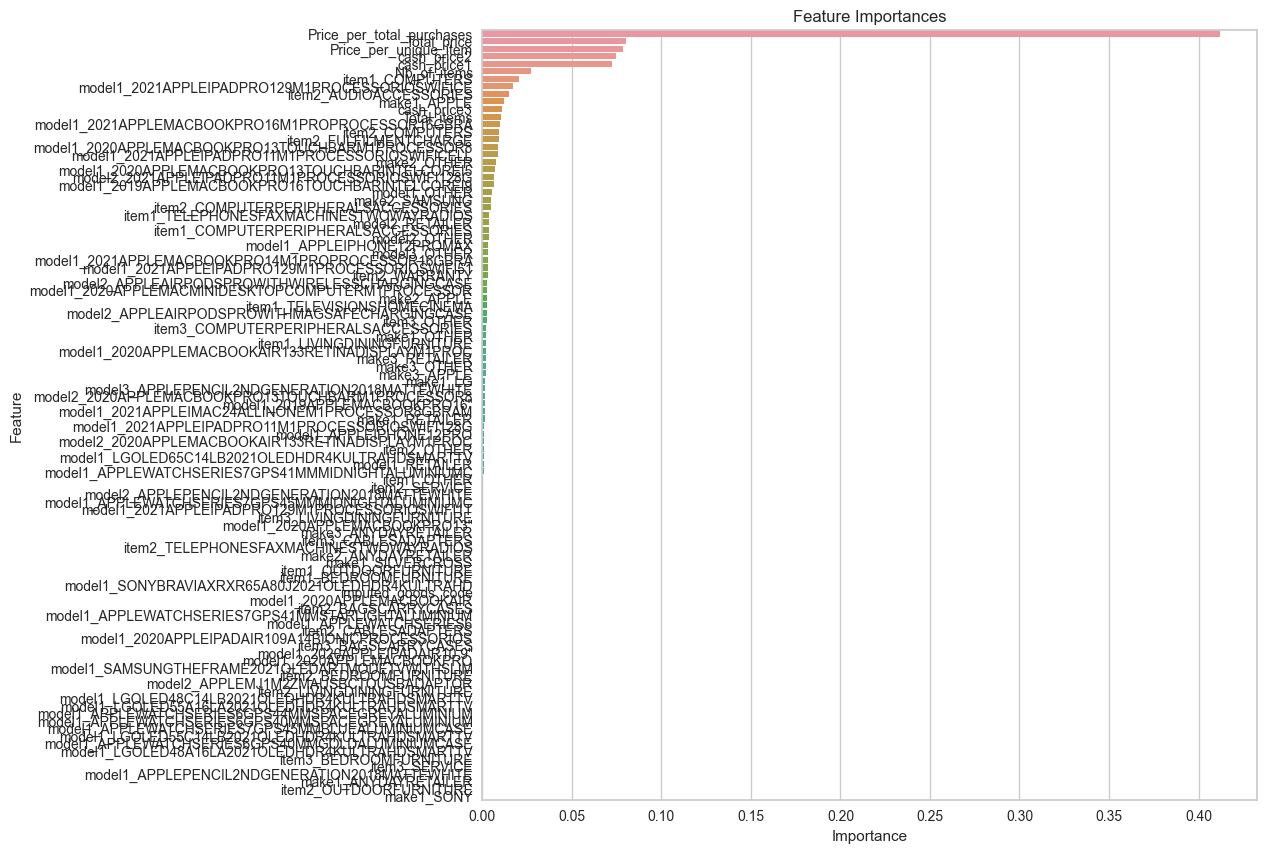

In [44]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(feature_importances.sort_values(by="Importance", ascending=False))

feature_importances.sort_values(by="Importance", ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Feature Importances")
plt.show()

- Arbitrary threshold of 50, to include the LG make

In [40]:
# Keep the first 50 features
feature_importances = feature_importances.iloc[:50]
feature_importances = feature_importances["Feature"].values

X_train = X_train[feature_importances]
y_train = data_encoded_train["fraud_flag"]

- RFE on the remaining (Takes 11 minutes and shows plateau for 20, we'll select 30)

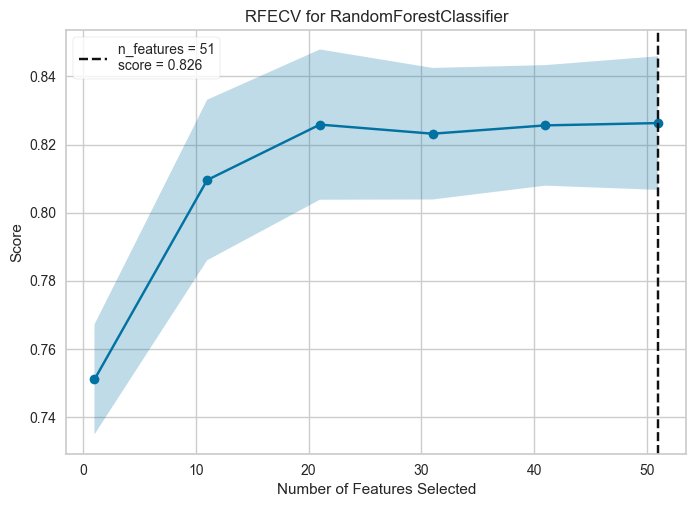

<Axes: title={'center': 'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import RFECV
from yellowbrick.datasets import load_credit

visualizer = RFECV(RandomForestClassifier(), X=X_train, y=y_train, step = 10, scoring='roc_auc', verbose=10)
visualizer.fit(X_train, y_train)
visualizer.show()

- Using SKlearn to select 30 features

In [48]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

selector = RFE(RandomForestClassifier(), n_features_to_select=30, step=1)
selector = selector.fit(X_train, y_train)

In [53]:
best_columns = X_train.loc[:, selector.support_].columns
# Pickle the best columns
import pickle
# with open('best_columns.pkl', 'wb') as f:
#     pickle.dump(best_columns, f)

- One way ANOVA

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

# Assuming data_train is your DataFrame

anova_results = pd.DataFrame(columns=['Column', 'F-statistic', 'P-value'])

for col in num_cols:
    fraud = data_encoded_train.loc[data_encoded_train["fraud_flag"] == 1, col]
    non_fraud = data_encoded_train.loc[data_encoded_train["fraud_flag"] == 0, col]
    f_statistic, p_value = f_oneway(fraud, non_fraud)
    anova_results = pd.concat([anova_results, pd.DataFrame({"Column": [col], "F-statistic": [f_statistic], "P-value": [p_value]})], axis=0).sort_values(by="P-value", ascending = True)

display(anova_results)

,Column,F-statistic,P-value
0,Price_per_total_purchases,604.047404,6.136210e-133
0,cash_price1,585.037399,7.858881e-129
0,Price_per_unique_item,569.579755,1.722174e-125
0,Total_price,454.368884,1.443311e-100
0,cash_price3,14.984305,1.084864e-04
0,cash_price2,9.240407,2.368011e-03


<Axes: xlabel='fraud_flag', ylabel='Total_price'>

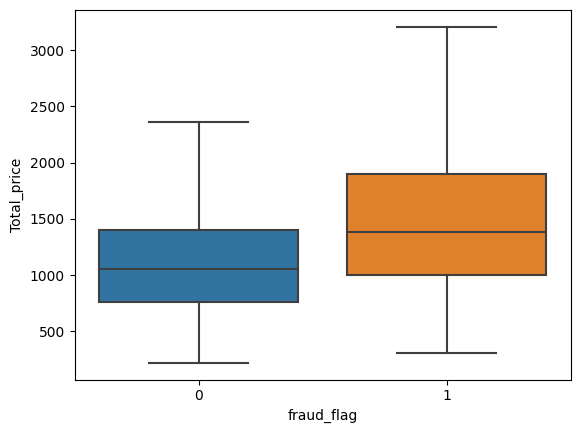

In [ ]:
# Boxplots without outliers

sns.boxplot(data = data_train, x = "fraud_flag", y = "Total_price", showfliers=False)

## 3 - Modeling

- Starting point here is the data encoded train & data encoded test sets, next steps will need to be :
    - Data Generation :
        - Generate fake data, and verify the data is decent to learn from
    - Tune the model :
        - Try different models and different combinations
    - Feature extraction :
        - 100 columns is too much, there are definitely optimizations to the columns we need
    - Evaluate :
        - Dig into where the model failed, and try to work on from there to help it

## a - Simple train test Random Forest model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.utils import resample

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_encoded_train.drop("fraud_flag", axis=1), data_encoded_train["fraud_flag"], test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_pred_train = rf_classifier.predict(X_train)
y_proba = rf_classifier.predict_proba(X_test)

# Evaluate the classifier on the testing data

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)

print(f'Accuracy: {100*accuracy_train:.2f} %')
print(f'Precision: {100*precision_train:.2f} %')
print(f'Recall: {100*recall_train:.2f} %')

print(f'Accuracy: {100*accuracy_test:.2f} %')
print(f'Precision: {100*precision_test:.2f} %')
print(f'Recall: {100*recall_test:.2f} %')

Accuracy: 99.00 %
Precision: 93.26 %
Recall: 31.55 %
Accuracy: 98.39 %
Precision: 64.04 %
Recall: 18.33 %


- Feature importance

In [ ]:
# Feature importance 

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_classifier.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
display(feature_importance)

,Feature,Importance
96,Price_per_total_purchases,0.283256
97,Price_per_unique_item,0.205913
94,Total_price,0.190460
95,Total_items,0.034092
93,Nb_of_items,0.015439
...,...,...
73,model1_LGOLED48A16LA2021OLEDHDR4KULTRAHDSMARTTV,0.000029
66,model1_APPLEWATCHSERIES6GPS40MMGOLDALUMINIUMCASE,0.000029
71,model1_APPLEWATCHSERIES7GPS45MMBLUEALUMINIUMCASE,0.000017
68,model1_APPLEWATCHSERIES6GPS44MMSPACEGREYALUMINIUM,0.000013


## b - Kaggle based XGB Classifier

In [30]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 100 #lgb early stop 
OPT_ROUNDS = 4000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

import xgboost as xgb
from sklearn.model_selection import train_test_split

# # Read the best columns
# with open('best_columns.pkl', 'rb') as f:
#     best_columns = pickle.load(f)

# best_columns = list(best_columns)
# best_columns.append("fraud_flag")

# data_encoded_train = data_encoded_train[best_columns]

train_df, test_df = train_test_split(data_encoded_train, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

predictors = list(data_encoded_train.drop("fraud_flag", axis=1).columns)
target = "fraud_flag"

# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters

params = {'eta': 0.01, 'max_depth': 20, 'subsample': 0.7039796847470207, 'colsample_bytree': 0.40824805571698625, 'min_samples_leaf': 3, 'min_samples_split': 2}

params['objective'] = 'binary:logistic'
params['silent'] = True
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

print(model.best_score)

plot_precision_recall_curve(test_df[target].values, model.predict(dtest))

create_submission(model.predict(xgb.DMatrix(data_encoded_test[predictors])), data_encoded_test.index, "submission_abid.csv")

[0]	train-auc:0.79469	valid-auc:0.78255


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.88890	valid-auc:0.85520
[100]	train-auc:0.89750	valid-auc:0.86424
[150]	train-auc:0.90316	valid-auc:0.86866
[200]	train-auc:0.90848	valid-auc:0.87073
[250]	train-auc:0.91258	valid-auc:0.87357
[300]	train-auc:0.91581	valid-auc:0.87463
[350]	train-auc:0.91859	valid-auc:0.87555
[400]	train-auc:0.92111	valid-auc:0.87587
[450]	train-auc:0.92346	valid-auc:0.87709
[500]	train-auc:0.92566	valid-auc:0.87726
[550]	train-auc:0.92767	valid-auc:0.87747
[600]	train-auc:0.92939	valid-auc:0.87696
[650]	train-auc:0.93079	valid-auc:0.87687
[662]	train-auc:0.93118	valid-auc:0.87688
0.8776450821905367


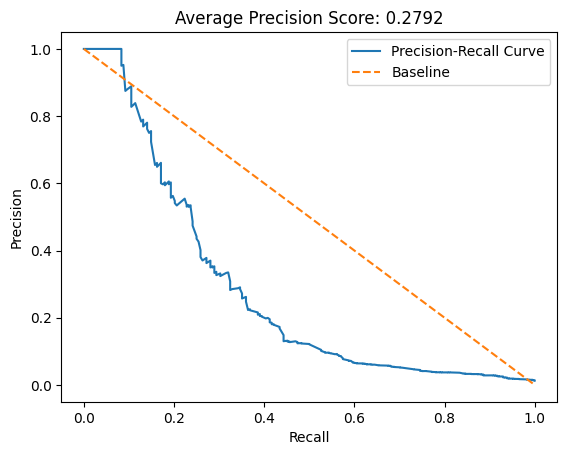

In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# # Read the best columns
# with open('best_columns.pkl', 'rb') as f:
#     best_columns = pickle.load(f)

# best_columns = list(best_columns)
# best_columns.append("fraud_flag")

# data_encoded_train = data_encoded_train[best_columns]

train_df, test_df = train_test_split(data_encoded_train, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

predictors = list(data_encoded_train.drop("fraud_flag", axis=1).columns)
target = "fraud_flag"

# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters

params = {'eta': 0.01, 'max_depth': 20, 'subsample': 0.7039796847470207, 'colsample_bytree': 0.40824805571698625, 'min_samples_leaf': 3, 'min_samples_split': 2}

params['objective'] = 'binary:logistic'
params['silent'] = True
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

print(model.best_score)

plot_precision_recall_curve(test_df[target].values, model.predict(dtest))

create_submission(model.predict(xgb.DMatrix(data_encoded_test[predictors])), data_encoded_test.index, "submission_abid.csv")

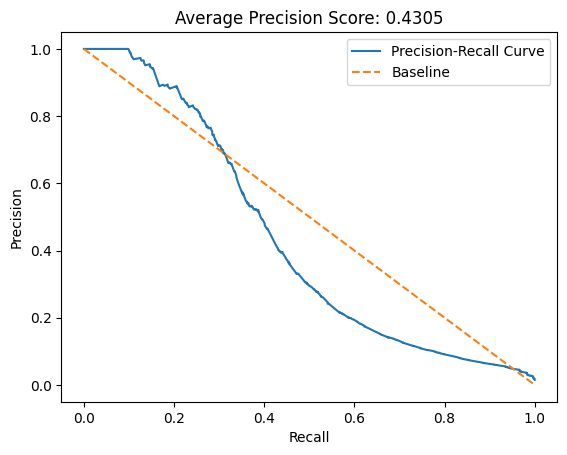

In [32]:
plot_precision_recall_curve(train_df[target].values, model.predict(dtrain))

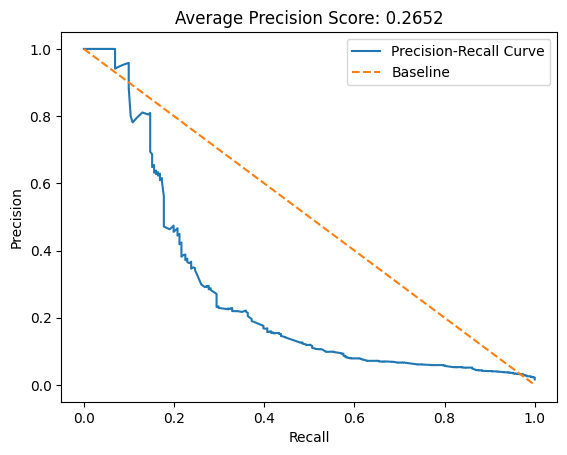

In [33]:
plot_precision_recall_curve(valid_df[target].values, model.predict(dvalid))

- Feature Importance

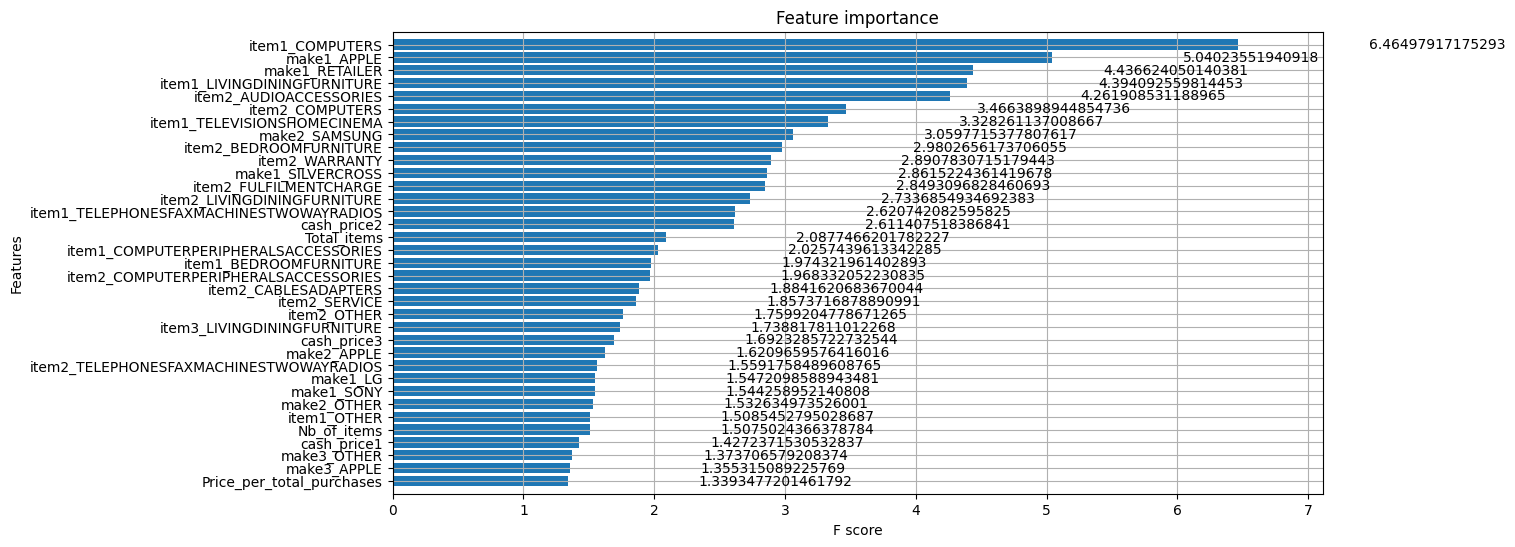

In [36]:
# Feature importance
fig, ax = plt.subplots(figsize=(12,6))
xgb.plot_importance(model, max_num_features=35, height=0.8, ax=ax,  importance_type='gain')
plt.show()

In [ ]:
all_cols = model.get_score(importance_type='gain').keys()
feature_importance = pd.DataFrame({'Feature': all_cols, 'Importance': model.get_score(importance_type='gain').values()}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

In [ ]:
best_features = list(feature_importance.iloc[:35]["Feature"].values)
best_features

['item1_COMPUTERS',
 'item2_COMPUTERS',
 'item2_AUDIOACCESSORIES',
 'model1_APPLEIPHONE12PROMAX',
 'make1_APPLE',
 'model1_2021APPLEIPADPRO11M1PROCESSORIOSWIFICELL',
 'item2_WARRANTY',
 'item1_TELEPHONESFAXMACHINESTWOWAYRADIOS',
 'item2_FULFILMENTCHARGE',
 'model1_2021APPLEIPADPRO129M1PROCESSORIOSWIFICE',
 'model1_2021APPLEIPADPRO11M1PROCESSORIOSWIFI128G',
 'model1_2020APPLEMACBOOKPRO13TOUCHBARINTELCOREI5',
 'make2_SAMSUNG',
 'model1_2019APPLEMACBOOKPRO16TOUCHBARINTELCOREI9',
 'Price_per_unique_item',
 'item1_LIVINGDININGFURNITURE',
 'model1_2021APPLEIMAC24ALLINONEM1PROCESSOR8GBRAM',
 'make1_RETAILER',
 'Price_per_total_purchases',
 'item2_COMPUTERPERIPHERALSACCESSORIES',
 'item1_OTHER',
 'Total_price',
 'item1_TELEVISIONSHOMECINEMA',
 'make1_SILVERCROSS',
 'model1_2020APPLEMACMINIDESKTOPCOMPUTERM1PROCESSOR',
 'make2_OTHER',
 'model2_2021APPLEIPADPRO11M1PROCESSORIOSWIFI128G',
 'make1_LG',
 'item3_OTHER',
 'Total_items',
 'model1_2020APPLEMACBOOKPRO13TOUCHBARM1PROCESSOR8',
 'model1_2021

## Retrain using a subset of features

[0]	train-aucpr:0.22213	valid-aucpr:0.18531


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-aucpr:0.31703	valid-aucpr:0.24872
[100]	train-aucpr:0.34426	valid-aucpr:0.25178
[150]	train-aucpr:0.36021	valid-aucpr:0.25238
[200]	train-aucpr:0.37608	valid-aucpr:0.25180
[222]	train-aucpr:0.38238	valid-aucpr:0.25117


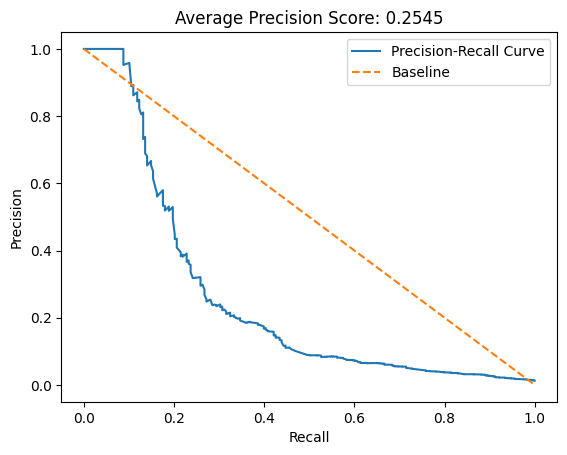

In [ ]:
import xgboost as xgb

data_train_xgb = data_encoded_train[best_features + ["fraud_flag"]].copy()
data_test_xgb = data_encoded_test[best_features].copy()

train_df, test_df = train_test_split(data_train_xgb, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

predictors = list(data_train_xgb.drop("fraud_flag", axis=1).columns)
target = "fraud_flag"

# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.04
params['silent'] = True
params['max_depth'] = 8
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'aucpr'
params['random_state'] = RANDOM_STATE

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

plot_precision_recall_curve(test_df[target].values, model.predict(dtest))

#create_submission(model.predict(xgb.DMatrix(data_encoded_test[predictors])), data_encoded_test.index, "submission.csv")

- Ad hoc for errors

In [ ]:
# Confusion matrix on dtrain

y_pred = model.predict(dtrain)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = dtrain.get_label()

# Import confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1], border = True)
disp.plot()

NameError: name 'model' is not defined

- Sample code for PR plot and PR AUC MAP score

In [ ]:
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

- Retrain using class balancing

In [ ]:
fake_data = pd.read_csv("../notebooks/Gretel Data.csv")
data_train_fake = pd.concat([data_train_xgb, fake_data[best_features + ["fraud_flag"]]], axis=0, ignore_index=True)

In [ ]:
data_train_fake

,make1_APPLE,item1_COMPUTERS,model1_APPLEIPHONE12PROMAX,item2_AUDIOACCESSORIES,item2_COMPUTERS,item1_TELEPHONESFAXMACHINESTWOWAYRADIOS,model1_2021APPLEIPADPRO11M1PROCESSORIOSWIFICELL,item2_FULFILMENTCHARGE,item2_WARRANTY,Total_items,...,model1_2021APPLEIPADPRO129M1PROCESSORIOSWIFICE,make2_SAMSUNG,Price_per_total_purchases,Total_price,model1_2020APPLEMACBOOKPRO13TOUCHBARINTELCOREI5,model1_2021APPLEIPADPRO11M1PROCESSORIOSWIFI128G,model1_2019APPLEMACBOOKPRO16TOUCHBARINTELCOREI9,make1_RETAILER,item1_OTHER,fraud_flag
0,1,1,0,0,0,0,0,0,0,1.0,...,0,0,889.000000,889.0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1.0,...,0,0,409.000000,409.0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1.0,...,0,0,1399.000000,1399.0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,2.0,...,0,0,404.000000,808.0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1.0,...,0,0,1199.000000,1199.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94026,1,0,0,1,0,0,0,0,0,1.0,...,0,0,251.887209,305.0,0,0,0,0,0,1
94027,0,0,0,0,0,0,0,1,0,2.0,...,0,0,93.333211,2107.0,0,0,0,0,0,1
94028,1,0,0,0,0,0,0,1,0,1.0,...,0,0,35.000000,2150.0,0,0,0,0,0,1
94029,1,0,0,1,0,0,0,1,0,2.0,...,0,0,1237.187738,1484.0,0,0,0,0,0,1


[0]	train-aucpr:0.81700	valid-aucpr:0.81503


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-aucpr:0.90683	valid-aucpr:0.89080
[100]	train-aucpr:0.91738	valid-aucpr:0.89675
[150]	train-aucpr:0.92327	valid-aucpr:0.89887
[200]	train-aucpr:0.92910	valid-aucpr:0.89969
[250]	train-aucpr:0.93254	valid-aucpr:0.90060
[300]	train-aucpr:0.93480	valid-aucpr:0.90023
[341]	train-aucpr:0.93625	valid-aucpr:0.89995


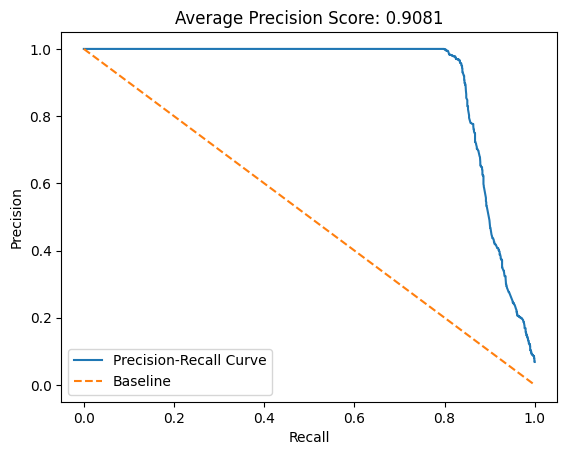

In [ ]:
import xgboost as xgb

data_train_fake = data_train_fake[best_features + ["fraud_flag"]].copy()
data_test_xgb = data_encoded_test[best_features].copy()

train_df, test_df = train_test_split(data_train_fake, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

predictors = list(data_train_fake.drop("fraud_flag", axis=1).columns)
target = "fraud_flag"

# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.04
params['silent'] = True
params['max_depth'] = 14
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'aucpr'
params['random_state'] = RANDOM_STATE

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

plot_precision_recall_curve(test_df[target].values, model.predict(dtest))

create_submission(model.predict(xgb.DMatrix(data_encoded_test[predictors])), data_encoded_test.index, "submission2.csv")

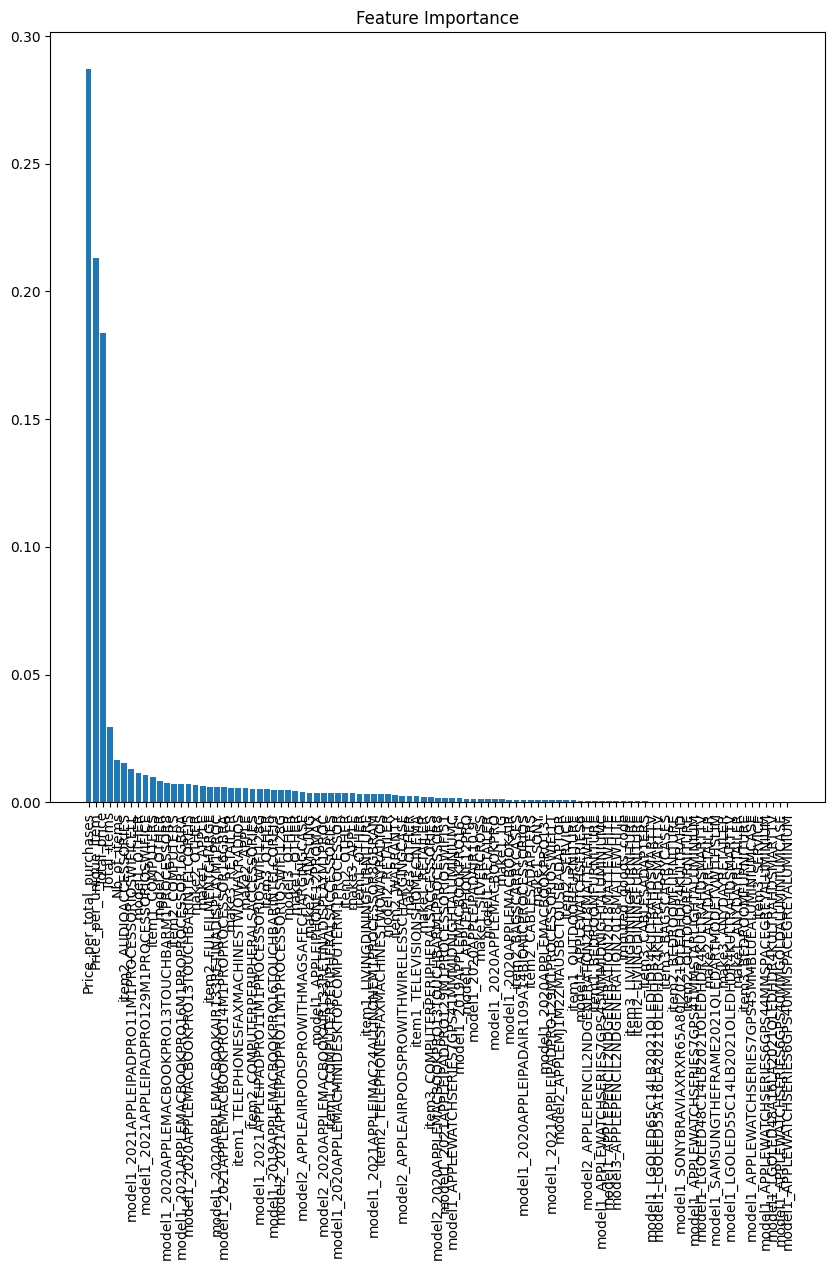

In [ ]:
feature_names = X_train.columns
feature_importances = rf_classifier.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 10))
plt.title("Feature Importance")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.show()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame({"Feature": feature_names[sorted_indices], "Importance": feature_importances[sorted_indices]}))

,Feature,Importance
0,Price_per_total_purchases,0.265826
1,Price_per_unique_item,0.226537
2,Total_price,0.183624
3,Total_items,0.034273
4,Nb_of_items,0.015018
5,item2_AUDIOACCESSORIES,0.014912
6,model1_OTHER,0.012589
7,item1_COMPUTERS,0.011299
8,model1_2021APPLEIPADPRO129M1PROCESSORIOSWIFICE,0.010777
9,model1_2021APPLEIPADPRO11M1PROCESSORIOSWIFICELL,0.010559


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

AttributeError: 'Booster' object has no attribute 'predict_label'

In [ ]:
data_encoded_test

,item1_BEDROOMFURNITURE,item1_COMPUTERPERIPHERALSACCESSORIES,item1_COMPUTERS,item1_LIVINGDININGFURNITURE,item1_OUTDOORFURNITURE,item1_TELEPHONESFAXMACHINESTWOWAYRADIOS,item1_TELEVISIONSHOMECINEMA,item1_OTHER,item2_AUDIOACCESSORIES,item2_BAGSCARRYCASES,...,model2_RETAILER,model2_OTHER,model3_APPLEPENCIL2NDGENERATION2018MATTEWHITE,model3_OTHER,Nb_of_items,Total_price,Total_items,Price_per_total_purchases,Price_per_unique_item,imputed_goods_code
ID,,,,,,,,,,,,,,,,,,,,,
64707,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1.0,399.0,1.0,399.0,399.0,0
63919,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1.0,294.0,1.0,294.0,294.0,0
15664,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.0,929.0,1.0,929.0,929.0,0
6626,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,2.0,546.0,2.0,273.0,273.0,0
26766,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.0,2470.0,1.0,2470.0,2470.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63474,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,2.0,516.0,2.0,258.0,258.0,0
80438,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1.0,1189.0,1.0,1189.0,1189.0,0
29485,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.0,1649.0,1.0,1649.0,1649.0,0


In [ ]:
res_xgb = pd.DataFrame({'ID': data_encoded_test.index, 'fraud_flag': model.predict(xgb.DMatrix(data_encoded_test))})

res_xgb.reset_index(inplace=True)
res_xgb.rename(columns={'index': 'index'}, inplace=True)
res_xgb.to_csv('output_file.csv', index=False)

def create_submission(prob_predictions, index, filename):
    res = pd.DataFrame({'ID': index, 'fraud_flag': prob_predictions})
    res.reset_index(inplace=True)
    res.rename(columns={'index': 'index'}, inplace=True)
    res.to_csv(filename, index=False)

In [ ]:
create_submission(model.predict(xgb.DMatrix(data_encoded_test)), data_encoded_test.index, 'output_file2.csv')

In [ ]:
res = rf_classifier.predict(data_encoded_test)

In [ ]:
res = pd.DataFrame({'ID': data_encoded_test.index, 'fraud_flag': rf_classifier.predict(data_encoded_test)})

In [ ]:
res.reset_index(inplace=True)
res.rename(columns={'index': 'index'}, inplace=True)
res.to_csv('output_file.csv', index=False)

In [ ]:
res

,index,ID,fraud_flag
0,0,64707,0
1,1,63919,0
2,2,15664,0
3,3,6626,0
4,4,26766,1
...,...,...,...
23193,23193,63474,0
23194,23194,80438,0
23195,23195,29485,0
23196,23196,59838,0
